<a href="https://colab.research.google.com/github/Jagabathula-Projects/news-based-forecasting/blob/main/foodprice_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdate
import datetime as dt
from statsmodels.tsa.api import SARIMAX
import gensim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from IPython import embed
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.api import OLS

# Reading the raw daily price data in Rs/quintal

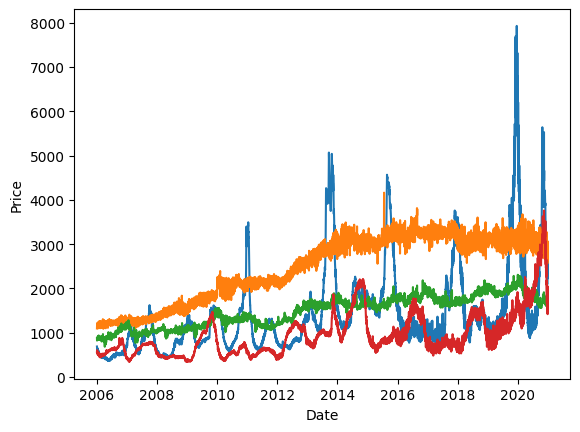

In [3]:
path = '/content/drive/MyDrive/MSOM_price_data/'
df_o = pd.read_csv(f'{path}Onion.csv', parse_dates = ['date'], index_col = ['date'])
df_o.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_o)

df_r = pd.read_csv(f'{path}Rice.csv', parse_dates = ['date'], index_col = ['date'])
df_r.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_r)

df_w = pd.read_csv(f'{path}Wheat.csv', parse_dates = ['date'], index_col = ['date'])
df_w.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_w)

df_p = pd.read_csv(f'{path}Potato.csv', parse_dates = ['date'], index_col = ['date'])
df_r.head()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(df_p)

dates =  pd.read_csv(f'{path}Onion.csv')['date']

#### Define constants

In [12]:
num_train_days = 2557 # till 2012
p=7
d=1
q=0
# forecast horizon
n_step_ahead = 7
kgs_in_quintal = 100
test_period_end = num_train_days + 2*365
crop_prices_dict = {'Onion': df_o, 'Potato': df_p, 'Rice': df_r, 'Wheat': df_w}
jump_threshold = 0.1

# Read different embeddings

In [5]:
test_event_embeddings = np.load(f'{path}events_test.npy')
train_event_embeddings = np.load(f'{path}events_train.npy')
train_topic_embeddings = np.load(f'{path}toi.maxLDA_train.npy')
test_topic_embeddings = np.load(f'{path}toi.maxLDA_test.npy')
train_word_embeddings = np.load(f'{path}toi.W2V_train.npy')
test_word_embeddings = np.load(f'{path}toi.W2V_test.npy')
# concatenate train and test
all_event_embeddings = np.vstack((train_event_embeddings, test_event_embeddings))
all_word_embeddings = np.vstack((train_word_embeddings, test_word_embeddings))
all_topic_embeddings = np.vstack((train_topic_embeddings, test_topic_embeddings))
all_embeddings_dict = {'events': all_event_embeddings, 'topics': all_topic_embeddings, 'w2v': all_word_embeddings}
# create based on size of train and test
train_event_embeddings = all_event_embeddings[:num_train_days]
test_event_embeddings = all_event_embeddings[num_train_days:]
train_word_embeddings = all_word_embeddings[:num_train_days]
test_word_embeddings = all_word_embeddings[num_train_days:]
train_topic_embeddings = all_topic_embeddings[:num_train_days]
test_topic_embeddings = all_topic_embeddings[num_train_days:]

Verify embeddings

In [ ]:
all_event_embeddings.max()

0.646179449834659

In [ ]:
np.unique(np.sum(all_event_embeddings, 1)) # ideally should sum up to 1

array([1., 1., 1., 1., 1., 1., 1.])

In [ ]:
all_topic_embeddings.max()

0.6023203134536743

In [ ]:
test_event_embeddings.shape, train_event_embeddings.shape, test_topic_embeddings.shape, train_topic_embeddings.shape, test_word_embeddings.shape, train_word_embeddings.shape

((2922, 250), (2557, 250), (2922, 250), (2557, 250), (2922, 250), (2557, 250))

In [ ]:
np.any(np.isnan(all_topic_embeddings), axis=1).sum()

0

In [ ]:
np.sum(all_topic_embeddings, 1).max()

0.9890244013132078

# Forecasting using ARIMA models

In [ ]:
def computeRMSE(tr, pred):
    err = 0
    for i in range(len(tr)):
        err += (tr[i]-pred[i])**2
    return np.sqrt(err/len(tr))
# Also compute the MAPE

In [ ]:
def ARIMA_forecasts(price_df, crop):
  df_train = price_df.iloc[:num_train_days]
  model = ARIMA(df_train, order=(p,d,q))
  # SARIMAX with period 365 takes too long to run so using the procedure given in the link below
  # https://github.com/statsmodels/statsmodels/issues/5727#issuecomment-660742852
  # model_fit = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
  # model = SARIMAX(df_train, order=(p,d,q))
  # default is 50 iterations which throws not converged warning
  model_fit = model.fit(method_kwargs={'maxiter': 200})
  arima_params = model_fit.params
  # model_fit = model.fit(maxiter=200)
  true_prices = price_df.iloc[num_train_days+n_step_ahead-1:test_period_end].values
  predictions = []
  # To make consistent with AutoReg implementation, report train RMSE ignoring first p+1 days
  print(f"ARIMA{(p,d,q)} train RMSE for {crop} = {mean_squared_error(df_train.iloc[p+1:], model_fit.predict().iloc[p+1:], squared=False):.2f}")
  for t in range(num_train_days, test_period_end - n_step_ahead + 1):
      # model = ARIMA(history, order=(p,d,q))
      # model_fit = model.fit()
      yhat = model_fit.forecast(steps=n_step_ahead).iloc[-1]
      predictions.append(yhat)
      model_fit = model_fit.extend(price_df.iloc[t:t+1])
      # history.append(testset[t])

  print(f"ARIMA{(p,d,q)} test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  return arima_params
  #print(f"ARIMA{(p,d,q)} test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

def ARIMA_plus_x_forecasts(price_df, crop, train_exog_embeddings, test_exog_embeddings, embedding_type, arima_params):
  df_train = price_df.iloc[:num_train_days]
  model = ARIMA(df_train, exog=train_exog_embeddings, order=(p,d,q))
  # model = SARIMAX(df_train, order=(p,d,q))
  # default is 50 iterations which throws not converged warning
  # https://github.com/statsmodels/statsmodels/issues/5727#issuecomment-660742852
  # model_fit = model.fit(method='innovations_mle', low_memory=True, cov_type='none')
  # model_fit = model.fit(maxiter=200)
  num_exog_features = train_exog_embeddings.shape[1]
  model_fit = model.fit(method_kwargs={'maxiter': 200}, start_params=np.append(np.zeros(num_exog_features), arima_params))
  true_prices = price_df.iloc[num_train_days+n_step_ahead-1:].values
  predictions = []
  print(f"ARIMA{(p,d,q)}+{embedding_type} train RMSE for {crop} = {mean_squared_error(df_train, model_fit.predict(), squared=False):.2f}")
  for t in range(num_train_days, len(price_df) - n_step_ahead + 1):
      new_events = test_exog_embeddings[t-num_train_days:t+n_step_ahead-num_train_days]
      # give the actual events, best possible performance
      yhat = model_fit.forecast(steps=n_step_ahead, exog=new_events).iloc[-1]
      # yhat = model_fit.forecast(steps=n_step_ahead, exog=np.repeat(new_events, n_step_ahead, axis=0)).iloc[-1]
      predictions.append(yhat)
      model_fit = model_fit.extend(price_df.iloc[t:t+1], exog=new_events[:1])

  print(f"ARIMA{(p,d,q)}+{embedding_type} test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  #print(f"ARIMA{(p,d,q)}+{embedding_type} test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

In [ ]:
crop_name = 'Wheat'
df_crop = crop_prices_dict[crop_name]
arima_params = ARIMA_forecasts(df_crop, crop_name)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_event_embeddings, test_event_embeddings, 'events', arima_params)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_topic_embeddings, test_topic_embeddings, 'topics', arima_params)
#ARIMA_plus_x_forecasts(df_crop, crop_name, train_word_embeddings, test_word_embeddings, 'w2v', arima_params)

ARIMA(7, 1, 0) train RMSE for Wheat = 38.91
ARIMA(7, 1, 0) test RMSE for Wheat = 44.17


# Forecasting using Autoregressive model

In [15]:
def AutoReg_forecasts(price_df, crop):
  diff_prices = price_df.diff()
  df_train = diff_prices.iloc[1:num_train_days] # ignore the first day
  model = AutoReg(df_train, lags=p, trend='n')
  model_fit = model.fit()
  true_prices = diff_prices.iloc[num_train_days+n_step_ahead-1:test_period_end]
  #jump_indicators = np.ravel(np.abs(true_prices.values)/price_df.iloc[num_train_days-1:test_period_end-1].values >= jump_threshold)
  predictions = np.array([])
  # cannot predict for first p days so compute train RMSE starting at day p
  print(f"AR-{p} with diff train RMSE for {crop} = {mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False):.2f}")
  for t in range(num_train_days, test_period_end - n_step_ahead + 1):
      yhat = model_fit.forecast(steps=n_step_ahead).iloc[-1]
      predictions = np.append(predictions, yhat)
      model_fit = model_fit.append(diff_prices.iloc[t:t+1])

  print(f"AR-{p} with diff test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  #print(f"AR-{p} with diff test shocks-RMSE for {crop} = {mean_squared_error(true_prices[jump_indicators], predictions[jump_indicators], squared=False):.2f}")

In [14]:
def AutoReg_plus_x_forecasts(price_df, crop, train_exog_embeddings, test_exog_embeddings, embedding_type):
  diff_prices = price_df.diff()
  df_train = diff_prices.iloc[1:num_train_days] # ignore the first day
  model = AutoReg(df_train, lags=p, trend='n', exog=train_exog_embeddings[1:])
  model_fit = model.fit()
  true_prices = diff_prices.iloc[num_train_days+n_step_ahead-1:test_period_end]
  # jump_indicators = np.ravel(np.abs(true_prices.values)/price_df.iloc[num_train_days-1:test_period_end-1].values >= jump_threshold)
  predictions = np.array([])
  # cannot predict for first p days so compute train RMSE starting at day p
  print(f"AR-{p}+{embedding_type} with diff train RMSE for {crop} = {mean_squared_error(df_train.iloc[p:], model_fit.predict().iloc[p:], squared=False):.2f}")
  for t in range(num_train_days, test_period_end - n_step_ahead + 1):
      new_events = test_exog_embeddings[t-num_train_days:t+n_step_ahead-num_train_days]
      yhat = model_fit.forecast(steps=n_step_ahead, exog=new_events).iloc[-1]
      predictions = np.append(predictions, yhat)
      model_fit = model_fit.append(diff_prices.iloc[t:t+1], exog=new_events[:1])

  print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  #print(f"AR-{p}+{embedding_type} with diff test shocks-RMSE for {crop} = {mean_squared_error(true_prices[jump_indicators], predictions[jump_indicators], squared=False):.2f}")

In [19]:
crop_name = 'Potato'
df_crop = crop_prices_dict[crop_name]
df_crop.index.freq = 'D'
AutoReg_forecasts(df_crop, crop_name)
AutoReg_plus_x_forecasts(df_crop, crop_name, train_topic_embeddings, test_topic_embeddings, 'LDA')
AutoReg_plus_x_forecasts(df_crop, crop_name, train_word_embeddings, test_word_embeddings, 'w2v')
AutoReg_plus_x_forecasts(df_crop, crop_name, train_event_embeddings, test_event_embeddings, 'events')

AR-7 with diff train RMSE for Potato = 20.75
AR-7 with diff test RMSE for Potato = 44.34
AR-7+LDA with diff train RMSE for Potato = 19.68
AR-7+LDA with diff test RMSE for Potato = 44.81
AR-7+w2v with diff train RMSE for Potato = 18.95
AR-7+w2v with diff test RMSE for Potato = 46.27
AR-7+events with diff train RMSE for Potato = 19.85
AR-7+events with diff test RMSE for Potato = 46.15


In [ ]:
df_train = df_o.iloc[:num_train_days]/kgs_in_quintal
model = ARIMA(df_train, order=(p,d,q))
model_fit = model.fit(method_kwargs={'maxiter': 200})
arima_params = model_fit.params
#model_fit = model.fit(maxiter=200)
# print(f"ARIMA{(p,d,q)} train RMSE for Onion = {mean_squared_error(df_train, model_fit.predict(), squared=False):.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Autoregression via OLS

In [ ]:
def add_previous_rows(matrix, date_index, n_prev_rows):
  # Initialize an empty list to store the transformed rows
  transformed_rows = []
  # Iterate through the rows of the matrix
  for i in range(len(matrix)):
    # Create a list to store the current row and values from the past 6 rows
    current_row = list(matrix[i])

    # Append values from the past rows or zeros if there are fewer than 6 previous rows
    for j in range(1, n_prev_rows + 1):
        if i - j >= 0:
            current_row.extend(matrix[i - j])
        else:
            current_row.extend([0] * len(matrix[0]))

    # Append the transformed row to the result
    transformed_rows.append(current_row)

  # Convert the result to a numpy array
  return pd.DataFrame(np.array(transformed_rows), index=date_index)

#### Prepare the data by appending past values

In [ ]:
crop = 'Onion'
embedding_type = 'w2v'
diff_prices = crop_prices_dict[crop].diff()
index = diff_prices.index[1:]
prices_rows_to_append = 6
events_rows_to_append = 0
all_price_data = add_previous_rows(diff_prices.iloc[1:].values, index, prices_rows_to_append)
all_event_data = add_previous_rows(all_embeddings_dict[embedding_type][1:], index, events_rows_to_append)
all_data = pd.concat([all_price_data, all_event_data], axis=1)

#### ARIMA(7,1,0)

In [ ]:
train_X = all_price_data.iloc[:num_train_days-1] # ignore first row since we do not have past y values
train_y = all_data.iloc[1:num_train_days, 0]
train_y.index = train_X.index
ols_model = OLS(train_y, train_X).fit()
test_y = all_data.iloc[num_train_days+n_step_ahead-1:test_period_end, 0]
test_X = all_price_data.iloc[num_train_days-1:test_period_end-1]
print(f"AR-{p} with diff train RMSE for {crop} = {mean_squared_error(train_y, ols_model.fittedvalues, squared=False):.2f}")
print(f"AR-{p} with diff test RMSE for {crop} = {mean_squared_error(test_y, ols_model.predict(test_X), squared=False):.2f}")

AR-7 with diff train RMSE for Onion = 35.85
AR-7 with diff test RMSE for Onion = 68.33


#### ARIMA(7,1,0)+events

In [ ]:
train_X = all_data.iloc[:num_train_days-1] # ignore first row since we do not have past y values
ols_model = OLS(train_y, train_X).fit()
test_X = all_data.iloc[num_train_days-1:test_period_end-1]
test_y = all_data.iloc[num_train_days+n_step_ahead-1:test_period_end, 0]
print(f"AR-{p}+{embedding_type} with diff train RMSE for {crop} = {mean_squared_error(train_y, ols_model.fittedvalues, squared=False):.2f}")
print(f"AR-{p}+{embedding_type} with diff test RMSE for {crop} = {mean_squared_error(test_y, ols_model.predict(test_X), squared=False):.2f}")

AR-7+w2v with diff train RMSE for Wheat = 36.89
AR-7+w2v with diff test RMSE for Wheat = 47.80


In [ ]:
ols_model.fittedvalues

date
2006-01-02    -3.685548
2006-01-03     1.888242
2006-01-04    -4.923638
2006-01-05    -5.183737
2006-01-06   -29.585981
                ...    
2012-12-27   -26.890954
2012-12-28   -29.758232
2012-12-29     1.938432
2012-12-30    61.419653
2012-12-31   -35.817869
Freq: D, Length: 2556, dtype: float64

In [ ]:
crop_name = 'Onion'
df_crop = df_o
df_crop.index.freq = 'D'
AutoReg_forecasts(df_crop, crop_name)
AutoReg_plus_x_forecasts(df_crop, crop_name, train_event_embeddings, test_event_embeddings, 'events')

AR-7 with diff train RMSE for Onion = 35.88
AR-7 with diff test RMSE for Onion = 68.33
AR-7+events with diff train RMSE for Onion = 34.11
AR-7+events with diff test RMSE for Onion = 71.21


In [ ]:
diff_prices = df_o.diff()
ar_prices_train = diff_prices.iloc[1:num_train_days] # ignore the first day
ar_prices_test = diff_prices.iloc[num_train_days:]

In [ ]:
ar_model = AutoReg(ar_prices_train, lags=p, trend='n')
ar_model_fit = ar_model.fit()
ar_params = ar_model_fit.params
#model_fit = model.fit(maxiter=200)
print(f"AR-{p} with diff train RMSE for Onion = {mean_squared_error(ar_prices_train, model_fit.predict(), squared=False):.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
ar_model_fit.params

price.L1   -0.149024
price.L2    0.030231
price.L3    0.082662
price.L4    0.083001
price.L5    0.010617
price.L6    0.023143
price.L7    0.278307
dtype: float64

In [ ]:
arx_model = AutoReg(ar_prices, lags=p, trend='n', exog=train_event_embeddings[1:])
arx_model_fit = arx_model.fit()
arx_params = arx_model_fit.params

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [ ]:
arx_model_fit.predict()

2006-01-02         NaN
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
                ...   
2012-12-27   -0.023135
2012-12-28   -0.091455
2012-12-29   -0.061538
2012-12-30   -0.130683
2012-12-31    0.295967
Freq: D, Length: 2556, dtype: float64

In [ ]:
earima_model = ARIMA(df_train, exog=train_event_embeddings, order=(p,d,q))
earima_model_fit = earima_model.fit(method_kwargs={'maxiter': 200})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
earima_model_fit.params['x1']

1812.0195223619269

In [ ]:
data_length = 2915
print(mean_squared_error(df_o.iloc[num_train_days:num_train_days+data_length], model_fit.predict(start=num_train_days, end=num_train_days+data_length-1), squared=False))

1159.4247423168952


In [ ]:
earima_model_fit.predict()

2006-01-01    48.617878
2006-01-02     6.601795
2006-01-03     6.332597
2006-01-04     6.356331
2006-01-05     6.411314
                ...    
2012-12-27    13.096935
2012-12-28    13.388280
2012-12-29    13.065289
2012-12-30    12.812405
2012-12-31    12.866016
Freq: D, Name: predicted_mean, Length: 2557, dtype: float64

In [ ]:
# df_o.head()
# df_o_test.mean()
# computeRMSE(predictions, true_prices)
# results.plot_predict(1, 5478)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Test RMSE for Onion = 277.54
Test MAPE for Onion = 0.08


ARIMA(7, 1, 0) train RMSE for Onion = 38.35
ARIMA(7, 1, 0) test RMSE for Onion = 165.75
ARIMA(7, 1, 0)+events train RMSE for Onion = 37.66
ARIMA(7, 1, 0)+events test RMSE for Onion = 166.10


KeyboardInterrupt: ignored

# Naive forecast


In [ ]:
def naive_forecasts(price_df, crop):
  true_prices = price_df.iloc[num_train_days+n_step_ahead-1:].values
  predictions = price_df.iloc[num_train_days-1:len(price_df) - n_step_ahead].values
  print(f"Test RMSE for {crop} = {mean_squared_error(true_prices, predictions, squared=False):.2f}")
  print(f"Test MAPE for {crop} = {mean_absolute_percentage_error(true_prices, predictions):.3f}")

In [ ]:
# Onion price forecast
naive_forecasts(df_o, 'Onion')

# Rice price forecast
naive_forecasts(df_r, 'Rice')

# Wheat price forecast
naive_forecasts(df_w, 'Wheat')

# Potato price forecast
naive_forecasts(df_p, 'Potato')

Test RMSE for Onion = 188.22
Test MAPE for Onion = 0.062
Test RMSE for Rice = 178.81
Test MAPE for Rice = 0.043
Test RMSE for Wheat = 65.56
Test MAPE for Wheat = 0.026
Test RMSE for Potato = 107.00
Test MAPE for Potato = 0.064


# Forecasting using ARIMA with transformed price data

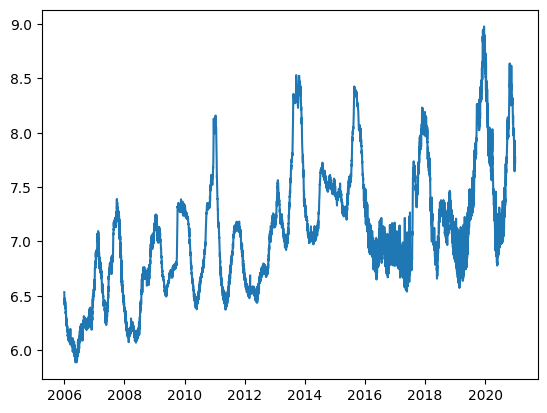

In [ ]:
df_log = np.log(df_o)
plt.plot(df_log)

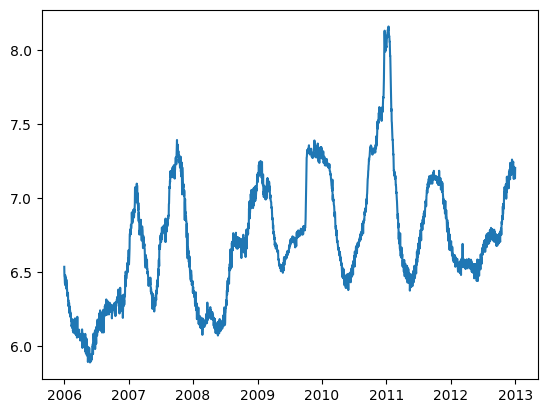

In [ ]:
df_log_train = np.log(df_o_train)
plt.plot(df_log_train)

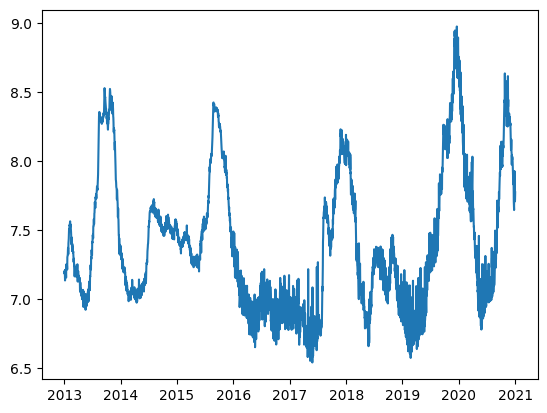

In [ ]:
df_log_test = np.log(df_o_test)
plt.plot(df_log_test)

In [ ]:
def get_stationarity(timeseries):
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Dickey–Fuller test:
    result = adfuller(timeseries['price'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

#### 1. Creating stationary time series by subtracting the rolling mean

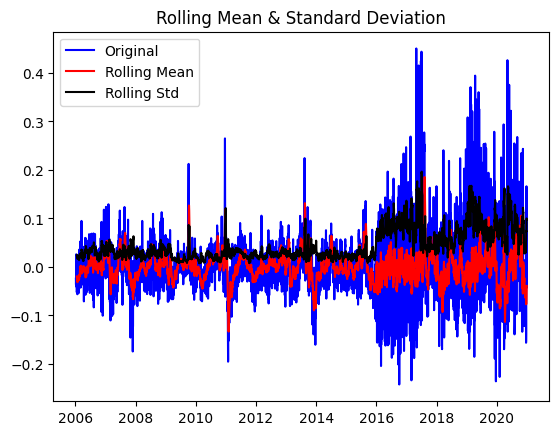

ADF Statistic: -9.241696122082502
p-value: 1.576239998872482e-15
Critical Values:
	1%: -3.4315522027214076
	5%: -2.862071253100843
	10%: -2.567052785036848


In [ ]:
rolling_mean = df_log.rolling(window=7).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

#### 2. Creating stationary time series using exponential decay

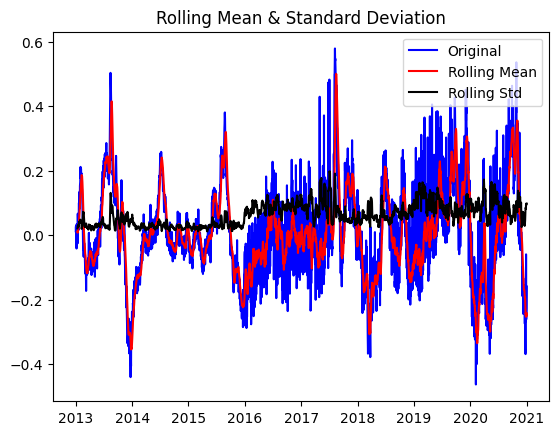

ADF Statistic: -5.241041031286708
p-value: 7.245193011779191e-06
Critical Values:
	1%: -3.432612396049843
	5%: -2.8625395742539688
	10%: -2.5673021019579663


In [ ]:
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log_test - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

#### 3. Creating stationary time series by time shifting

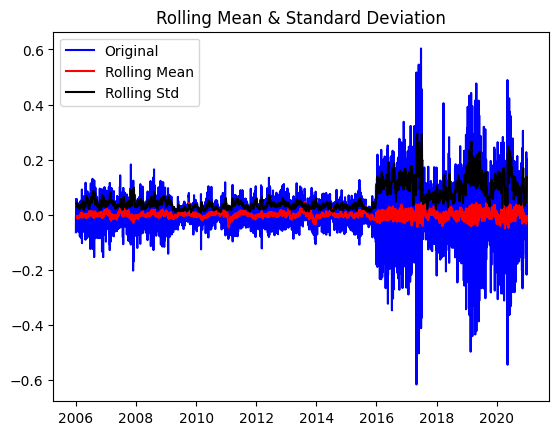

ADF Statistic: -9.485789897894836
p-value: 3.7661066050445027e-16
Critical Values:
	1%: -3.4315517608513493
	5%: -2.862071057878025
	10%: -2.5670526811133167


In [ ]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [ ]:
model = ARIMA(df_o_train, order=(7,1,2))
results = model.fit()
print (results.fittedvalues.shape)
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


(2557,)
                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                 2557
Model:                 ARIMA(7, 1, 2)   Log Likelihood              -12773.866
Date:                Wed, 13 Sep 2023   AIC                          25567.732
Time:                        02:42:51   BIC                          25626.194
Sample:                    01-01-2006   HQIC                         25588.932
                         - 12-31-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0012      0.051     -0.023      0.982      -0.100       0.098
ar.L2          0.0555      0.046      1.199      0.231      -0.035       0.146
ar.L3          0.0777      0.015      5.111 

#### A. Forecast using log values

In [ ]:
#decomposition = seasonal_decompose(df_log_test)
#Raw: df_o_test
#log: df_log_test
#stationarity1: df_log_minus_mean
#stationarity2: df_log_exp_decay
#stationarity3: df_log_shift

p=7
q=30
d=2
for p in [1, 7, 14]:#,30]:
    for q in [1,7,14]:#,30]:
        for d in range(1,3):
            print("model: %d,%d,%d"%(p,d,q))
            #try:
            if True:
                model = ARIMA(df_log_shift, order=(p,d,q))
                results = model.fit()
                # plt.plot(df_log_shift)
                # plt.plot(results.fittedvalues, color='red')


                predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
                predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
                predictions_ARIMA_log = pd.Series(df_log_test['price'].iloc[0], index=df_log_test.index)
                predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
                predictions_ARIMA = np.exp(predictions_ARIMA_log)
                print('---------------------------------')
                print(df_o_test[:10])
                print(predictions_ARIMA[:10])
                #print(computeRMSE(df_o_test,predictions_ARIMA))

                plt.plot(df_o_test,label="True")
                plt.plot(predictions_ARIMA,label="Predicted")
                plt.legend(loc = 'best')
                plt.title("Onion - (%d,%d,%d)"%(p,d,q))
                plt.savefig("/content/drive/MyDrive/MSOM_price_data/Onion - (%d,%d,%d)_stat3.png"%(p,d,q))
                plt.clf()

            #plt.savefig("Onion.png")
            # except Exception as error:
            #     wr = open("error.log","a")
            #     wr.write("model: %d,%d,%d\n"%(p,d,q))
            #     wr.write(str(error))
            #     wr.write("\n\n========================================================\n\n")
            #     wr.close()

model: 1,1,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.895700
2006-01-05    0.869810
2006-01-06    0.843893
2006-01-07    0.809159
2006-01-08    0.808938
2006-01-09    0.801918
2006-01-10    0.786598
2006-01-11    0.758998
dtype: float64
model: 1,2,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.974150
2006-01-06    0.965190
2006-01-07    1.009275
2006-01-08    1.049901
2006-01-09    1.015354
2006-01-10    1.001684
2006-01-11    1.036474
dtype: float64
model: 1,1,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.899863
2006-01-05    0.871322
2006-01-06    0.842216
2006-01-07    0.802475
2006-01-08    0.787713
2006-01-09    0.776037
2006-01-10    0.768115
2006-01-11    0.737497
dtype: float64
model: 1,2,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.968193
2006-01-06    0.967111
2006-01-07    1.012239
2006-01-08    1.053593
2006-01-09    1.070740
2006-01-10    1.086280
2006-01-11    1.094562
dtype: float64
model: 1,1,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.899224
2006-01-05    0.869852
2006-01-06    0.841704
2006-01-07    0.802786
2006-01-08    0.795465
2006-01-09    0.779301
2006-01-10    0.765760
2006-01-11    0.728429
dtype: float64
model: 1,2,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.966461
2006-01-06    0.969028
2006-01-07    1.011327
2006-01-08    1.053627
2006-01-09    1.067723
2006-01-10    1.080628
2006-01-11    1.086777
dtype: float64
model: 7,1,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.898981
2006-01-05    0.869275
2006-01-06    0.841596
2006-01-07    0.803213
2006-01-08    0.799784
2006-01-09    0.779103
2006-01-10    0.767106
2006-01-11    0.727755
dtype: float64
model: 7,2,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.965502
2006-01-06    0.968459
2006-01-07    1.013090
2006-01-08    1.055344
2006-01-09    1.062020
2006-01-10    1.082065
2006-01-11    1.095844
dtype: float64
model: 7,1,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.898271
2006-01-05    0.869583
2006-01-06    0.842029
2006-01-07    0.804424
2006-01-08    0.802862
2006-01-09    0.780313
2006-01-10    0.764580
2006-01-11    0.728063
dtype: float64
model: 7,2,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.970058
2006-01-06    0.968606
2006-01-07    1.008972
2006-01-08    1.058033
2006-01-09    1.066738
2006-01-10    1.087216
2006-01-11    1.094133
dtype: float64
model: 7,1,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.897207
2006-01-05    0.868204
2006-01-06    0.841388
2006-01-07    0.798240
2006-01-08    0.797562
2006-01-09    0.779090
2006-01-10    0.764698
2006-01-11    0.723941
dtype: float64
model: 7,2,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.966847
2006-01-06    0.969217
2006-01-07    1.010915
2006-01-08    1.051308
2006-01-09    1.069414
2006-01-10    1.077167
2006-01-11    1.083175
dtype: float64
model: 14,1,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.899019
2006-01-05    0.868630
2006-01-06    0.840356
2006-01-07    0.799223
2006-01-08    0.796336
2006-01-09    0.776458
2006-01-10    0.761073
2006-01-11    0.719478
dtype: float64
model: 14,2,1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.969332
2006-01-06    0.970191
2006-01-07    1.007199
2006-01-08    1.055687
2006-01-09    1.051940
2006-01-10    1.065841
2006-01-11    1.081651
dtype: float64
model: 14,1,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.898960
2006-01-05    0.869645
2006-01-06    0.842082
2006-01-07    0.805102
2006-01-08    0.801429
2006-01-09    0.780286
2006-01-10    0.763059
2006-01-11    0.721924
dtype: float64
model: 14,2,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.966489
2006-01-06    0.969488
2006-01-07    1.010859
2006-01-08    1.055547
2006-01-09    1.069579
2006-01-10    1.084493
2006-01-11    1.090594
dtype: float64
model: 14,1,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.938583
2006-01-04    0.898456
2006-01-05    0.868745
2006-01-06    0.839770
2006-01-07    0.798484
2006-01-08    0.794434
2006-01-09    0.776655
2006-01-10    0.762157
2006-01-11    0.720542
dtype: float64
model: 14,2,14


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  

---------------------------------
                  price
date                   
2013-01-01  1322.899761
2013-01-02  1344.678487
2013-01-03  1325.252955
2013-01-04  1330.063830
2013-01-05  1313.734211
2013-01-06  1254.943723
2013-01-07  1355.877934
2013-01-08  1340.323741
2013-01-09  1322.883610
2013-01-10  1353.946387
date
2006-01-02    1.000000
2006-01-03    0.909304
2006-01-04    0.958344
2006-01-05    0.967116
2006-01-06    0.968661
2006-01-07    1.010905
2006-01-08    1.050274
2006-01-09    1.048993
2006-01-10    1.058803
2006-01-11    1.076319
dtype: float64


<Figure size 640x480 with 0 Axes>

#### B. Forecast using stationary series (using method 3)

In [ ]:


#decomposition = seasonal_decompose(df_log_test)

#Raw: df_o_test
#log: df_log_test
#stationarity1: df_log_minus_mean
#stationarity2: df_log_exp_decay
#stationarity3: df_log_shift
p=7
q=30
d=2
for p in [1, 7]:#,30]:
    for q in [1,7]:#,30]:
        for d in range(0,2):

            try:
                print("model: %d,%d,%d"%(p,d,q))
                model = ARIMA(df_log_shift, order=(p,d,q))
                results = model.fit(disp=-1)
                # plt.plot(df_log_shift)
                # plt.plot(results.fittedvalues, color='red')


                predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
                predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
                predictions_ARIMA_log = pd.Series(df_log_test['price'].iloc[0], index=df_log_test.index)
                predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
                predictions_ARIMA = np.exp(predictions_ARIMA_log)


                plt.plot(df_o_test,label="True")
                plt.plot(predictions_ARIMA,label="Predicted")
                plt.legend(loc = 'best')
                plt.title("Onion - (%d,%d,%d)"%(p,d,q))
                plt.savefig("plots/Onion - (%d,%d,%d)_stat3.png"%(p,d,q))
                plt.clf()
            #plt.savefig("Onion.png")
            except Exception as error:
                wr = open("error.log","a")
                wr.write("model: %d,%d,%d\n"%(p,d,q))
                wr.write(str(error))
                wr.write("\n\n========================================================\n\n")
                wr.close()

model: 1,0,1
model: 1,1,1
model: 1,0,7
model: 1,1,7
model: 7,0,1
model: 7,1,1
model: 7,0,7
model: 7,1,7


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

#### C. Forecast using stationary series (using method 2)

In [ ]:
#decomposition = seasonal_decompose(df_log_test)

#Raw: df_o_test
#log: df_log_test
#stationarity1: df_log_minus_mean
#stationarity2: df_log_exp_decay
#stationarity3: df_log_shift
p=7
q=30
d=2
for p in [1, 7]:#,30]:
    for q in [1,7]:#,30]:
        for d in range(0,2):
            print("model: %d,%d,%d"%(p,d,q))
            try:
                model = ARIMA(df_log_exp_decay, order=(p,d,q))
                results = model.fit(disp=-1)
                # plt.plot(df_log_shift)
                # plt.plot(results.fittedvalues, color='red')


                predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
                predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
                predictions_ARIMA_log = pd.Series(df_log_test['price'].iloc[0], index=df_log_test.index)
                predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
                predictions_ARIMA = np.exp(predictions_ARIMA_log)


                plt.plot(df_o_test,label="True")
                plt.plot(predictions_ARIMA,label="Predicted")
                plt.legend(loc = 'best')
                plt.title("Onion - (%d,%d,%d)"%(p,d,q))
                plt.savefig("plots/Onion - (%d,%d,%d)_stat2.png"%(p,d,q))
                plt.clf()
            #plt.savefig("Onion.png")
            except Exception as error:
                wr = open("error.log","a")
                wr.write("model: %d,%d,%d\n"%(p,d,q))
                wr.write(str(error))
                wr.write("\n\n========================================================\n\n")
                wr.close()

#### D. Forecast using stationary series  (using method 1)

In [ ]:
#decomposition = seasonal_decompose(df_log_test)

#Raw: df_o_test
#log: df_log_test
#stationarity1: df_log_minus_mean
#stationarity2: df_log_exp_decay
#stationarity3: df_log_shift
p=7
q=30
d=2
for p in [1, 7]:#,30]:
    for q in [1,7]:#,30]:
        for d in range(0,2):
            print("model: %d,%d,%d"%(p,d,q))
            #try:
            if True:
                model = ARIMA(df_log_minus_mean, order=(p,d,q))
                results = model.fit()
                # plt.plot(df_log_shift)
                # plt.plot(results.fittedvalues, color='red')


                predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
                predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
                predictions_ARIMA_log = pd.Series(df_log_test['price'].iloc[0], index=df_log_test.index)
                predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
                predictions_ARIMA = np.exp(predictions_ARIMA_log)


                plt.plot(df_o_test,label="True")
                plt.plot(predictions_ARIMA[2557:],label="Predicted")
                plt.legend(loc = 'best')
                plt.title("Onion - (%d,%d,%d)"%(p,d,q))
                plt.savefig("plots/Onion - (%d,%d,%d)_stat1.png"%(p,d,q))
                plt.clf()
            #plt.savefig("Onion.png")
#             except Exception as error:
#                 wr = open("error.log","a")
#                 wr.write("model: %d,%d,%d\n"%(p,d,q))
#                 wr.write(str(error))
#                 wr.write("\n\n========================================================\n\n")
#                 wr.close()